<a href="https://www.kaggle.com/code/rishitjakharia/uci-har-pytorch?scriptVersionId=212811643" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torchinfo import summary
from tqdm import tqdm

import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
from pandas import read_csv

In [2]:
import random
import os

seed_value = 42

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
# torch.use_deterministic_algorithms(True)

'cuda'

# Loading Dataset

In [3]:
train = pd.read_csv('/kaggle/input/har-using-deep-nn/train.csv')
train.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
4525,0.283203,-0.047024,-0.168986,0.384949,0.176898,-0.310332,0.381757,0.122611,-0.332984,0.465563,...,-0.034924,0.558036,0.258975,-0.854858,-0.78433,0.22296,-0.066506,22,3,WALKING_DOWNSTAIRS


In [4]:
train.shape

(7352, 564)

In [5]:
test = pd.read_csv('/kaggle/input/har-using-deep-nn/test.csv')
test.sample()

,tBodyAcc_mean_X,tBodyAcc_mean_Y,tBodyAcc_mean_Z,tBodyAcc_std_X,tBodyAcc_std_Y,tBodyAcc_std_Z,tBodyAcc_mad_X,tBodyAcc_mad_Y,tBodyAcc_mad_Z,tBodyAcc_max_X,...,angletBodyAccMeangravity,angletBodyAccJerkMeangravityMean,angletBodyGyroMeangravityMean,angletBodyGyroJerkMeangravityMean,angleXgravityMean,angleYgravityMean,angleZgravityMean,subject,Activity,ActivityName
718,0.3659,-0.031332,-0.024079,0.183421,-0.344568,-0.403268,0.09989,-0.3422,-0.412337,0.4803,...,-0.37837,-0.840289,-0.864326,0.848585,-0.960939,0.116422,-0.003858,9,3,WALKING_DOWNSTAIRS


In [6]:
test.shape

(2947, 564)

In [7]:
print('Duplicates in train = {}'.format(sum(train.duplicated())))
print('Duplicates in test = {}'.format(sum(test.duplicated())))
print('Invalid values in train = {}'.format(train.isnull().values.sum()))
print('Invalid values in test = {}'.format(test.isnull().values.sum()))

Duplicates in train = 0
Duplicates in test = 0
Invalid values in train = 0
Invalid values in test = 0


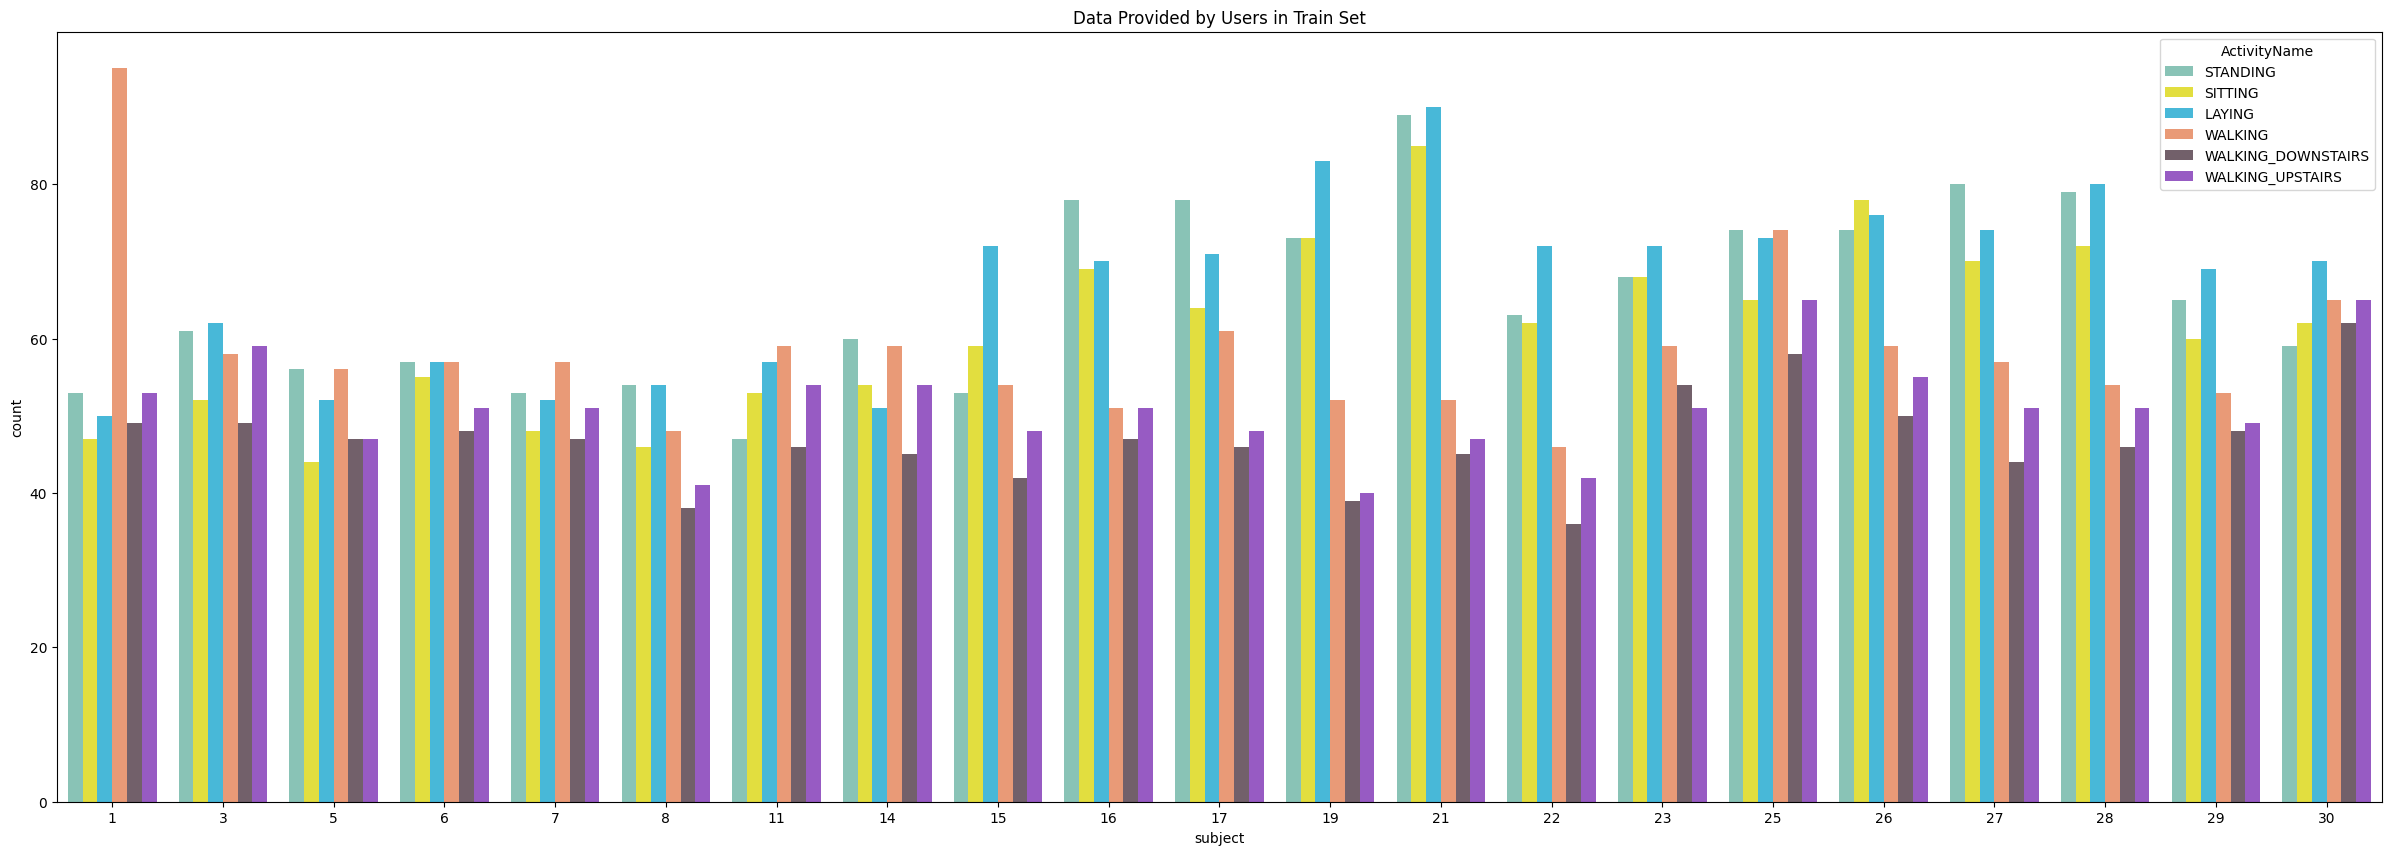

In [8]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = train)
plt.title('Data Provided by Users in Train Set')
plt.show()

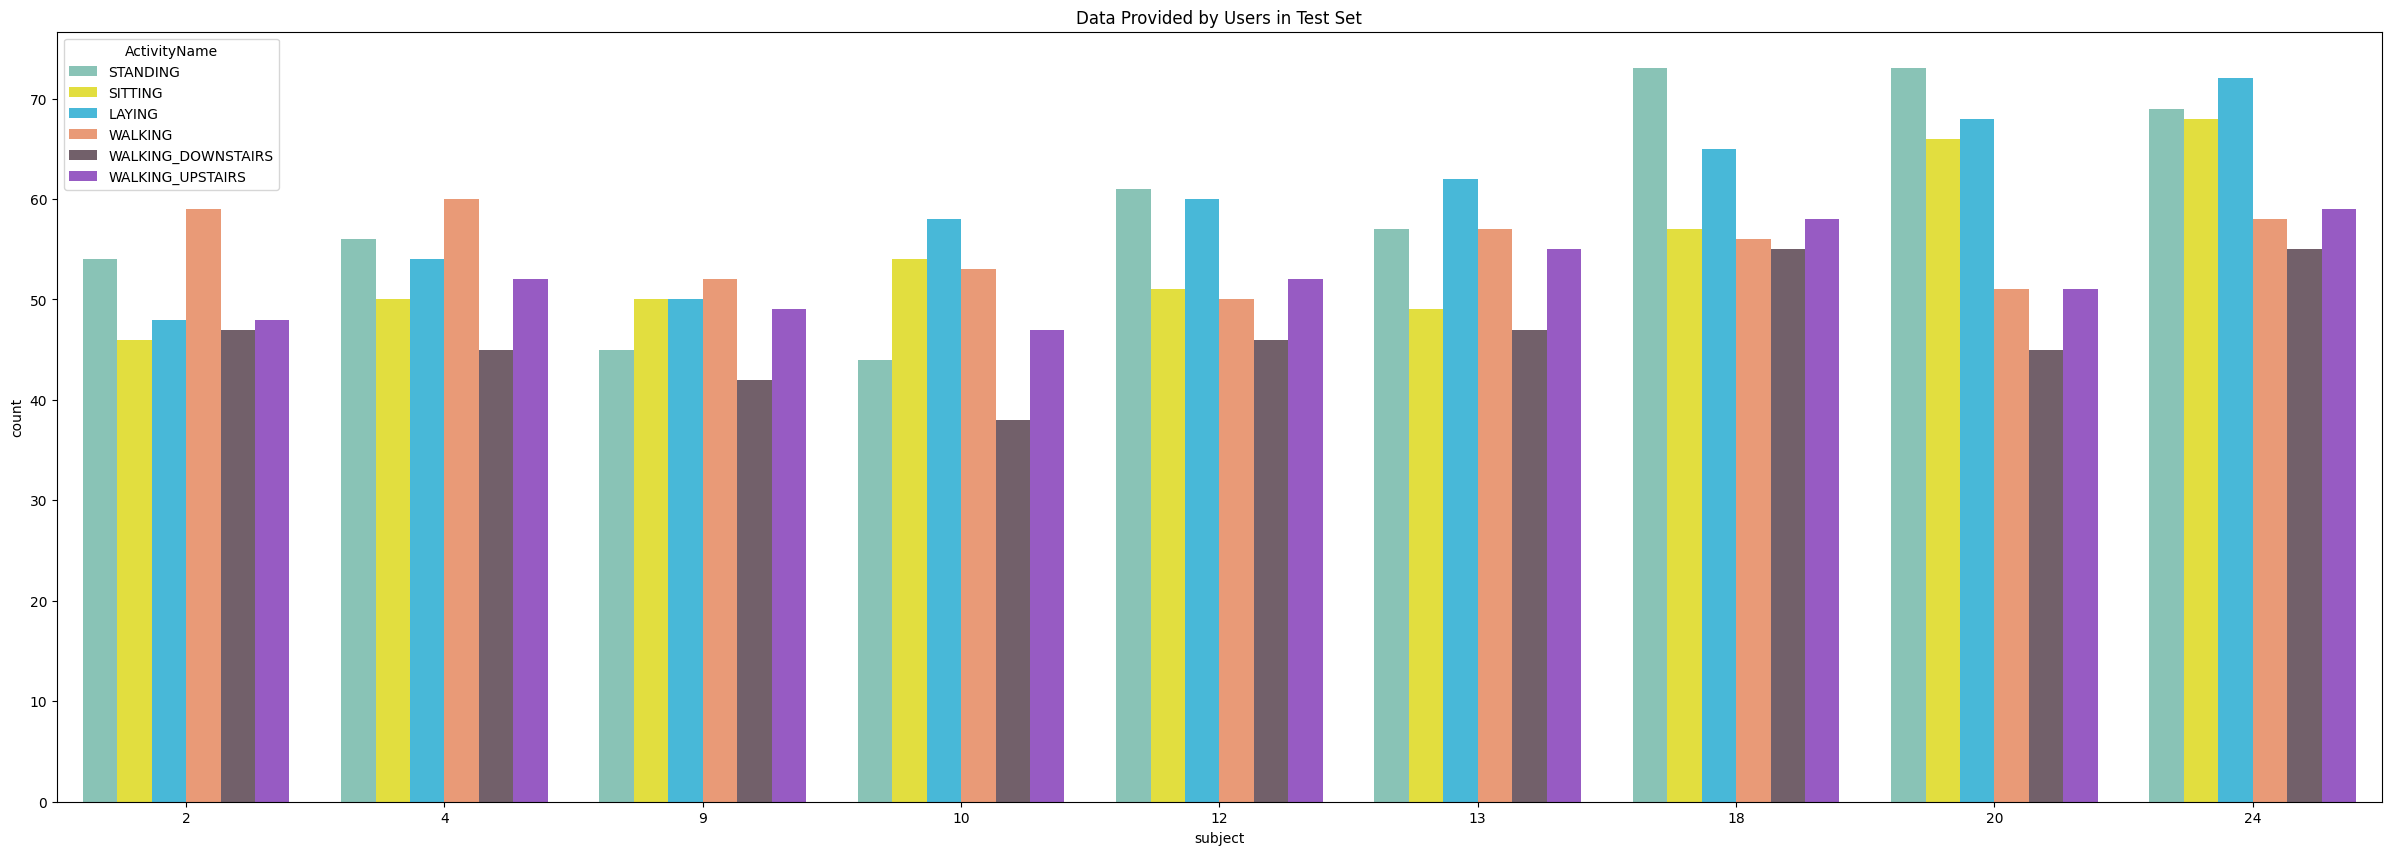

In [9]:
plt.figure(figsize=(30,10))
sns.countplot(x='subject',hue='ActivityName',palette= ["#7fcdbb","#fdf824","#30c6f0","#fc9264","#755d6b","#9a4ad4"], data = test)
plt.title('Data Provided by Users in Test Set')
plt.show()

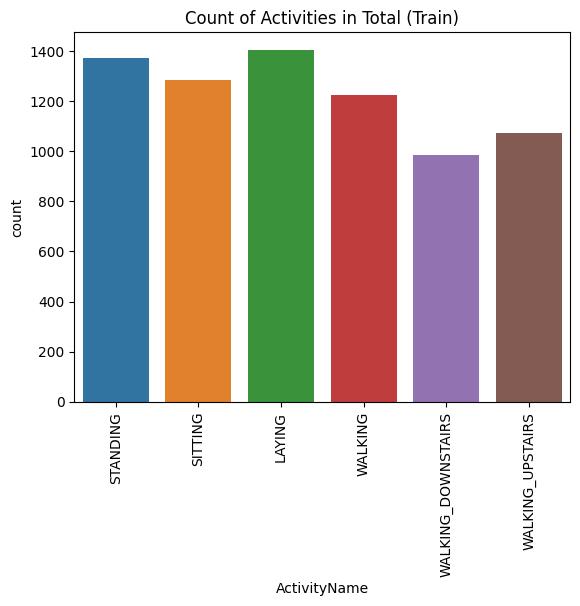

In [10]:
plt.title('Count of Activities in Total (Train)')
sns.countplot(x="ActivityName",data=train)
plt.xticks(rotation=90)
plt.show()

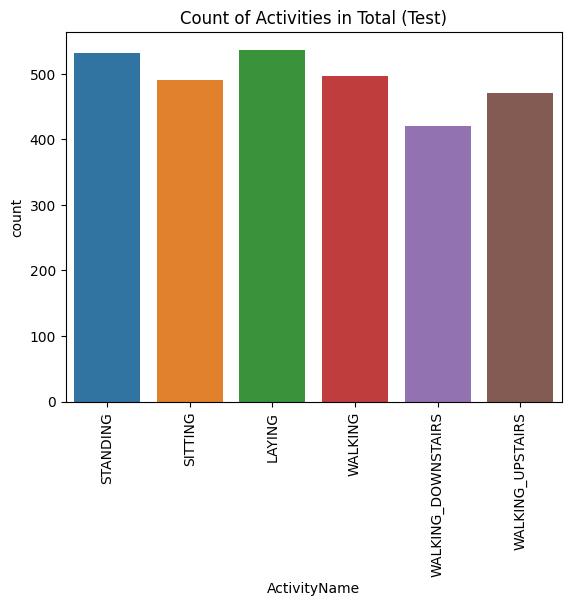

In [11]:
plt.title('Count of Activities in Total (Test)')
sns.countplot(x="ActivityName",data=test)
plt.xticks(rotation=90)
plt.show()

In [12]:
def file_load(filepath):
    df = read_csv(filepath, header=None, sep='\s+')
    return df.values

In [13]:
def train_test_append(filenames, append_before=''):
    datalist = list()
    for name in filenames:
        data = file_load(append_before + name)
        datalist.append(data)
    datalist = np.dstack(datalist)
    return datalist

In [14]:
def inertial_signals_load(group, append_before=''):
    filepath = append_before + group + '/Inertial Signals/'
    filenames = list()
    filenames += ['total_acc_x_'+group+'.txt', 'total_acc_y_'+group+'.txt', 'total_acc_z_'+group+'.txt']
    filenames += ['body_acc_x_'+group+'.txt', 'body_acc_y_'+group+'.txt', 'body_acc_z_'+group+'.txt']
    filenames += ['body_gyro_x_'+group+'.txt', 'body_gyro_y_'+group+'.txt', 'body_gyro_z_'+group+'.txt']
    X = train_test_append(filenames, filepath)
    y = file_load(append_before + group + '/y_'+group+'.txt')
    return X, y

In [15]:
def load_dataset(append_before=''):
    trainX, trainy = inertial_signals_load('train', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    testX, testy = inertial_signals_load('test', append_before + '/kaggle/input/ucihar-dataset/UCI-HAR Dataset/')
    trainy = trainy - 1
    testy = testy - 1
    trainy = pd.get_dummies(trainy[:,0], dtype=int).values
    testy = pd.get_dummies(testy[:,0], dtype=int).values
    print(trainX.shape, trainy.shape, testX.shape, testy.shape)
    return trainX, trainy, testX, testy

In [16]:
trainX, trainy, testX, testy = load_dataset()
verbose, epochs, batch_size = 0, 100, 200
n_timesteps = trainX.shape[1]
n_features = trainX.shape[2]
n_outputs = trainy.shape[1]
# n_steps = 4
# n_length = 32
# trainX = trainX.reshape((trainX.shape[0], n_steps, n_length, n_features))
# testX = testX.reshape((testX.shape[0], n_steps, n_length, n_features)) 
print(trainX.shape,testX.shape)

(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)
(7352, 128, 9) (2947, 128, 9)


## Setting Up the train and test loaders

In [17]:
class HARDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [18]:
train_dataset = HARDataset(trainX, trainy)
test_dataset = HARDataset(testX, testy)

BATCH = 256
train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

## Preprocessing

In [19]:
mean = torch.zeros(128, 9)  # Shape (128, 9)
sum_sq = torch.zeros(128, 9)  # Shape (128, 9)
total_elements = 0

for batch, _ in train_loader:
    batch_size = batch.size(0)
    
    mean += batch.sum(dim=0)
    sum_sq += (batch ** 2).sum(dim=0)
    total_elements += batch_size

mean /= total_elements  # Shape (128, 9)
std = torch.sqrt(sum_sq / total_elements - mean ** 2)  # Shape (128, 9)

# print("Mean:", mean)
# print("Standard Deviation:", std)

In [20]:
class Normalize:
    def __init__(self, mean, std, device=None):
        self.mean = mean.to(device) if device else mean
        self.std = std.to(device) if device else std
    
    def __call__(self, sample):
        if not isinstance(sample, torch.Tensor):
            sample = torch.tensor(sample, dtype=torch.float32)
        
        normalized_sample = (sample - self.mean) / self.std
        return normalized_sample

class AddNoise:
    def __init__(self, noise_level=0.01):
        self.noise_level = noise_level

    def __call__(self, sample):
        noise = torch.randn_like(sample) * self.noise_level
        return sample + noise

In [21]:
class DatasetWithAugmentation(Dataset):
    def __init__(self, data, target, transforms=None):
        self.data = data
        self.target = target
        self.transforms = transforms

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        target = self.target[idx]

        if self.transforms:
            for transform in self.transforms:
                sample = transform(sample)

        return sample, target

normalize_transform = Normalize(torch.Tensor(mean), torch.Tensor(std))
add_noise_transform = AddNoise(noise_level=0.02)

transforms = [normalize_transform, add_noise_transform]
# transforms = [normalize_transform]

train_dataset = DatasetWithAugmentation(trainX, trainy, transforms=transforms)
test_dataset = DatasetWithAugmentation(testX, testy, transforms=transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH, shuffle=False)

# Modelling

## Loss Function

In [22]:
def kl_divergence_loss(preds, targets):
    targets = targets.float()
    
    preds = F.softmax(preds, dim=-1)
    targets = F.softmax(targets, dim=-1)
    loss = F.kl_div(preds.log(), targets, reduction='batchmean')
    return loss

def mse_loss(preds, targets):
    # Ensure that the predictions and targets are one-hot encoded
    preds = F.softmax(preds, dim=-1)
    return F.mse_loss(preds, targets)

# Focal Loss
def focal_loss(preds, targets, alpha=0.25, gamma=2.0):
    """
    Focal Loss for multi-class classification.
    
    Arguments:
    preds -- the raw logits from the model (shape: [batch_size, num_classes])
    targets -- the true labels (shape: [batch_size])
    alpha -- balancing factor for class imbalances (default is 0.25)
    gamma -- focusing parameter (default is 2.0)
    
    Returns:
    loss -- the computed focal loss
    """
    # Apply softmax to get probabilities
    preds = F.softmax(preds, dim=-1)
    
    # Convert targets to one-hot encoding
    targets_one_hot = targets
    
    # Cross-entropy loss
    ce_loss = F.cross_entropy(preds, targets, reduction='none')
    
    # Get the predicted probability for the correct class
    pt = torch.exp(-ce_loss)
    
    # Compute focal loss
    focal_loss = alpha * (1 - pt) ** gamma * ce_loss
    
    return focal_loss.mean()

# criterion = nn.CrossEntropyLoss() # -> 96.89% 93.55%
# criterion = kl_divergence_loss # -> 99.09% 94.81%
# criterion = mse_loss # -> 96.27% 92.94%
# criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # -> 97.43% 94.06%
# criterion = focal_loss # -> 97.27% 93.32%

## Optimizer and Learning Rate

In [23]:
def warmup_lr(epoch, step_size, warmup_epochs=5, gamma=0.1):
    if epoch < warmup_epochs:
        return (epoch + 1) / warmup_epochs
    
    else:
        epoch_since_warmup = epoch - warmup_epochs
        return gamma ** (epoch_since_warmup // step_size)

WARMUP_EPOCHS = 14
GAMMA = 0.1
STEP_SIZE = 20

## Plotting Train and Test Acc and Loss

In [24]:
# Plot history
def plot_history(history):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 4))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train Loss')
    plt.plot(epochs, history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss History')

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train Accuracy')
    plt.plot(epochs, history['val_acc'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy History')

    plt.show()

## Confusion Matrix Function

In [25]:
def plot_confusion_matrix(model, val_loader, class_names, device="cuda"):
    """
    Evaluates the model and plots a confusion matrix with a custom color map.

    Arguments:
    - model: Trained PyTorch model.
    - val_loader: DataLoader for validation dataset.
    - class_names: List of class names for the confusion matrix.
    - device: 'cuda' or 'cpu'.
    """
    model.eval()  # Set model to evaluation mode
    all_preds = []
    all_labels = []

    with torch.no_grad():  # Disable gradient computation
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)  # Predicted classes
            
            # If labels are one-hot encoded, convert them to class indices
            if len(labels.shape) > 1 and labels.size(1) > 1:
                labels = torch.argmax(labels, dim=1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(all_labels, all_preds, labels=np.arange(len(class_names)))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    # Plot the confusion matrix with customization
    fig, ax = plt.subplots(figsize=(10, 8))  # Set larger figure size
    disp.plot(cmap="YlGnBu", ax=ax, colorbar=True)  # Use "cividis" colormap and add colorbar
    plt.title("Confusion Matrix", fontsize=16)
    plt.xticks(fontsize=12, rotation=45)
    plt.yticks(fontsize=12)
    plt.show()

## Training Function

In [34]:
def train_model(model, train_loader, val_loader, criterion=None, optimizer=None, scheduler=None, epochs=20, device='cpu', early_stopping=False, save_path='best_model.pth'):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

    patience = 20
    min_delta = 1e-3
    best_loss = np.inf
    best_acc = -np.inf
    patience_counter = 0
    best_model_state = None  # Store the best model in memory

    if criterion is None:
        criterion = F.mse_loss
    _criterion = criterion

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0.0, 0
        
        # Training phase
        with tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} - Training", unit="batch") as tepoch:
            for inputs, targets in tepoch:
                inputs = inputs.to(device)
                targets = targets.to(device)
                
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = _criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() * inputs.size(0)
                train_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                tepoch.set_postfix(loss=loss.item())

        if scheduler is not None:
            scheduler.step()

        train_loss /= len(train_loader.dataset)
        train_acc = train_correct / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss, val_correct = 0.0, 0
        with torch.no_grad():
            with tqdm(val_loader, desc=f"Epoch {epoch+1}/{epochs} - Validation", unit="batch") as vepoch:
                for inputs, targets in vepoch:
                    inputs = inputs.to(device)
                    targets = targets.to(device)
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, targets)
                    val_loss += loss.item() * inputs.size(0)
                    val_correct += (outputs.argmax(1) == targets.argmax(1)).sum().item()

                    vepoch.set_postfix(loss=loss.item())

        val_loss /= len(val_loader.dataset)
        val_acc = val_correct / len(val_loader.dataset)

        # Save history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # Update the best model in memory
        if best_acc < val_acc - min_delta:
            best_loss = val_loss
            best_acc = val_acc
            patience_counter = 0
            best_model_state = model.state_dict()
            print(f"New best model found at epoch {epoch+1} with val_loss: {val_loss:.4f}")
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience and early_stopping and epoch > 100:
            print("Early stopping triggered!")
            break

    # Save the best model at the end of training
    if best_model_state is not None:
        torch.save(best_model_state, save_path)
        print(f"Best model saved to {save_path} with val_loss: {best_loss:.4f} and val_acc: {best_acc:.4f}")

    return history

## Models

### RNN + Attention

In [28]:
class AdaptiveRNN(nn.Module):
    def __init__(self, n_timesteps, n_features, n_outputs):
        super(AdaptiveRNN, self).__init__()

        # Bi-directional LSTM layer
        self.lstm = nn.LSTM(
            input_size=n_features,
            hidden_size=128,
            batch_first=True,
            bidirectional=True
        )
        self.batch_norm = nn.BatchNorm1d(128 * 2)

        # Attention mechanism
        self.attention_dense = nn.Linear(128 * 2, 1)
        
        # Fully connected layers
        self.fc1 = nn.Linear(128 * 2, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        # LSTM output
        lstm_out, _ = self.lstm(x)  # lstm_out shape: (batch_size, timesteps, 128*2)
        
        batch_size, n_timesteps, n_features = lstm_out.size()
        lstm_out = lstm_out.reshape(batch_size * n_timesteps, n_features)
        lstm_out = self.batch_norm(lstm_out)
        lstm_out = lstm_out.reshape(batch_size, n_timesteps, n_features)
        
        # Attention mechanism
        attention_scores = torch.sigmoid(self.attention_dense(lstm_out))  # (batch_size, timesteps, 1)
        attention_scores = lstm_out * attention_scores  # Weighted timesteps

        # Global average pooling
        pooled = attention_scores.mean(dim=1)
        
        # Fully connected layers
        x = F.relu(self.fc1(pooled))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return F.softmax(x, dim=1)

In [ ]:
# Define the model parameters
n_timesteps = 32 * 4  # 128 timesteps
n_features = 9
n_outputs = 6

# Create the model
model = AdaptiveRNN(n_timesteps=n_timesteps, n_features=n_features, n_outputs=n_outputs).to(device)
summary(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=False)

In [ ]:
plot_history(history)

### TCN Model

In [29]:
class TCNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation_rate):
        super(TCNBlock, self).__init__()

        self.conv1 = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size,
            padding='same',
            dilation=dilation_rate
        )
        self.batch_norm = nn.BatchNorm1d(out_channels)

        # Residual connection
        if in_channels != out_channels:
            self.shortcut = nn.Conv1d(in_channels, out_channels, kernel_size=1)
        else:
            self.shortcut = None

    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = self.batch_norm(out)

        shortcut = self.shortcut(x) if self.shortcut is not None else x
        return F.relu(out + shortcut)

class TCNModel(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNModel, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 64, kernel_size=3, dilation_rate=8)
        )

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(64, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [ ]:
# Instantiate model
model = TCNModel(n_length, n_features, n_outputs).to(device)
summary(model)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=1e-3)
# scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda x: warmup_lr(x, warmup_epochs=WARMUP_EPOCHS, gamma=GAMMA, step_size=STEP_SIZE))
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 50, eta_min = 1e-6)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=True)

In [ ]:
plot_history(history)

In [ ]:
plot_confusion_matrix(model, test_loader, class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])

### TCN + CBAM Model

In [30]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=8):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)
        self.fc1 = nn.Conv1d(in_channels, in_channels // reduction_ratio, kernel_size=1)
        self.fc2 = nn.Conv1d(in_channels // reduction_ratio, in_channels, kernel_size=1)

    def forward(self, x):
        avg_pool = self.avg_pool(x)
        max_pool = self.max_pool(x)

        avg_out = F.relu(self.fc1(avg_pool))
        avg_out = self.fc2(avg_out)

        max_out = F.relu(self.fc1(max_pool))
        max_out = self.fc2(max_out)

        out = avg_out + max_out
        return torch.sigmoid(out) * x  # Channel attention applied

class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Conv1d(2, 1, kernel_size=kernel_size, padding=kernel_size//2)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_pool = torch.mean(x, dim=1, keepdim=True)
        max_pool, _ = torch.max(x, dim=1, keepdim=True)
        x_cat = torch.cat([avg_pool, max_pool], dim=1)  # Concatenate along channel dimension
        out = self.conv(x_cat)
        return self.sigmoid(out) * x  # Spatial attention applied

class CBAMBlock(nn.Module):
    def __init__(self, in_channels):
        super(CBAMBlock, self).__init__()
        self.channel_attention = ChannelAttention(in_channels)
        self.spatial_attention = SpatialAttention()

    def forward(self, x):
        x = self.channel_attention(x)
        x = self.spatial_attention(x)
        return x

class TCNWithCBAM(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNWithCBAM, self).__init__()

        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 256, kernel_size=3, dilation_rate=8)
        ) # (batch_size, out_channels, n_length)

        self.cbam_block = CBAMBlock(256)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        x = self.tcn_blocks(x)

        # Apply CBAM
        x = self.cbam_block(x)

        x = self.global_avg_pool(x).squeeze(-1)  # Global average pooling

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Define model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [ ]:
model = TCNWithCBAM(n_length, n_features, n_outputs).to(device)
summary(model)

In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)

history = train_model(model, train_loader, test_loader, criterion=kl_divergence_loss, epochs=150, device=device, early_stopping=True)

In [ ]:
plot_history(history)

In [ ]:
plot_confusion_matrix(model, test_loader, class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])

### TCN + Self Attention

In [55]:
class SelfAttention(nn.Module):
    def __init__(self, in_channels, d_k=64, d_v=64):
        super(SelfAttention, self).__init__()
        
        self.query = nn.Conv1d(in_channels, d_k, kernel_size=1)
        self.key = nn.Conv1d(in_channels, d_k, kernel_size=1)
        self.value = nn.Conv1d(in_channels, d_v, kernel_size=1)
        
        self.attn_fc = nn.Linear(d_v, in_channels)

    def forward(self, x):
        # x: (batch_size, channels, seq_length)
        
        Q = self.query(x)  # Query: (batch_size, d_k, seq_length)
        K = self.key(x)    # Key: (batch_size, d_k, seq_length)
        V = self.value(x)  # Value: (batch_size, d_v, seq_length)

        # Scaled dot-product attention
        attn_scores = torch.bmm(Q.transpose(1, 2), K)  # (batch_size, seq_length, seq_length)
        attn_scores = attn_scores / (Q.size(-1) ** 0.5)  # Scaling
        
        attn_weights = F.softmax(attn_scores, dim=-1)  # (batch_size, seq_length, seq_length)
        
        # Attention output
        attn_output = torch.bmm(attn_weights, V.transpose(1, 2))  # (batch_size, seq_length, d_v)
        attn_output = attn_output.transpose(1, 2)  # (batch_size, d_v, seq_length)

        # Combine with input
        output = self.attn_fc(attn_output)
        output = output.permute(0, 2, 1)
        return output + x  # Add residual connection


# TCN + Self-Attention Model
class TCNWithAttention(nn.Module):
    def __init__(self, n_length, n_features, n_outputs):
        super(TCNWithAttention, self).__init__()

        # TCN Blocks
        self.tcn_blocks = nn.Sequential(
            TCNBlock(n_features, 64, kernel_size=3, dilation_rate=1),
            TCNBlock(64, 128, kernel_size=3, dilation_rate=2),
            TCNBlock(128, 256, kernel_size=3, dilation_rate=4),
            TCNBlock(256, 256, kernel_size=3, dilation_rate=8)
        ) # (batch_size, out_channels, n_length)

        # Self-Attention Layer
        self.self_attention = SelfAttention(in_channels=256, d_k=128, d_v=128)

        # Fully connected layers after TCN and Attention
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, n_outputs)

        self.dropout = nn.Dropout(0.5)
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # Convert to (batch_size, n_features, n_length)
        
        # TCN blocks for feature extraction
        x = self.tcn_blocks(x)
        x = self.dropout(x)

        # Apply Self-Attention
        x = self.self_attention(x)

        # Global average pooling
        x = self.global_avg_pool(x).squeeze(-1)  # (batch_size, channels)

        # Fully connected layers for classification
        x = F.relu(self.fc1(x))
        x = self.batch_norm1(x)
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.batch_norm2(x)
        x = self.dropout(x)
        x = self.fc3(x)

        return F.softmax(x, dim=1)

# Model parameters
n_length = 128  
n_features = 9
n_outputs = 6

In [68]:
model = TCNWithAttention(n_length, n_features, n_outputs).to(device)
summary(model)

Layer (type:depth-idx)                   Param #
TCNWithAttention                         --
├─Sequential: 1-1                        --
│    └─TCNBlock: 2-1                     --
│    │    └─Conv1d: 3-1                  1,792
│    │    └─BatchNorm1d: 3-2             128
│    │    └─Conv1d: 3-3                  640
│    └─TCNBlock: 2-2                     --
│    │    └─Conv1d: 3-4                  24,704
│    │    └─BatchNorm1d: 3-5             256
│    │    └─Conv1d: 3-6                  8,320
│    └─TCNBlock: 2-3                     --
│    │    └─Conv1d: 3-7                  98,560
│    │    └─BatchNorm1d: 3-8             512
│    │    └─Conv1d: 3-9                  33,024
│    └─TCNBlock: 2-4                     --
│    │    └─Conv1d: 3-10                 196,864
│    │    └─BatchNorm1d: 3-11            512
├─SelfAttention: 1-2                     --
│    └─Conv1d: 2-5                       32,896
│    └─Conv1d: 2-6                       32,896
│    └─Conv1d: 2-7                 

In [73]:
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50, eta_min=1e-6)


loss_fn = lambda inputs, targets: 0.9*kl_divergence_loss(inputs, targets) + 0.1*nn.CrossEntropyLoss()(inputs.float(), targets.float())
history = train_model(model, train_loader, test_loader, optimizer=optimizer, criterion= loss_fn, epochs=150, device=device, early_stopping=True)

Epoch 1/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.28batch/s, loss=0.104]


Epoch 1/150 - Train Loss: 0.1083, Train Acc: 0.9861 - Val Loss: 0.1252, Val Acc: 0.9274
New best model found at epoch 1 with val_loss: 0.1252


Epoch 2/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.74batch/s, loss=0.104]


Epoch 2/150 - Train Loss: 0.1071, Train Acc: 0.9908 - Val Loss: 0.1226, Val Acc: 0.9365
New best model found at epoch 2 with val_loss: 0.1226


Epoch 3/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.13batch/s, loss=0.104]


Epoch 3/150 - Train Loss: 0.1074, Train Acc: 0.9894 - Val Loss: 0.1238, Val Acc: 0.9338


Epoch 4/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.96batch/s, loss=0.104]


Epoch 4/150 - Train Loss: 0.1069, Train Acc: 0.9913 - Val Loss: 0.1241, Val Acc: 0.9267


Epoch 5/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.48batch/s, loss=0.104]


Epoch 5/150 - Train Loss: 0.1074, Train Acc: 0.9897 - Val Loss: 0.1260, Val Acc: 0.9233


Epoch 6/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.35batch/s, loss=0.104]


Epoch 6/150 - Train Loss: 0.1071, Train Acc: 0.9905 - Val Loss: 0.1255, Val Acc: 0.9240


Epoch 7/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.79batch/s, loss=0.104]


Epoch 7/150 - Train Loss: 0.1072, Train Acc: 0.9902 - Val Loss: 0.1232, Val Acc: 0.9335


Epoch 8/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.60batch/s, loss=0.104]


Epoch 8/150 - Train Loss: 0.1069, Train Acc: 0.9909 - Val Loss: 0.1219, Val Acc: 0.9386
New best model found at epoch 8 with val_loss: 0.1219


Epoch 9/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.48batch/s, loss=0.104]


Epoch 9/150 - Train Loss: 0.1069, Train Acc: 0.9912 - Val Loss: 0.1268, Val Acc: 0.9213


Epoch 10/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.90batch/s, loss=0.104]


Epoch 10/150 - Train Loss: 0.1069, Train Acc: 0.9910 - Val Loss: 0.1201, Val Acc: 0.9440
New best model found at epoch 10 with val_loss: 0.1201


Epoch 11/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.89batch/s, loss=0.104]


Epoch 11/150 - Train Loss: 0.1066, Train Acc: 0.9924 - Val Loss: 0.1195, Val Acc: 0.9464
New best model found at epoch 11 with val_loss: 0.1195


Epoch 12/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.38batch/s, loss=0.104]


Epoch 12/150 - Train Loss: 0.1069, Train Acc: 0.9912 - Val Loss: 0.1211, Val Acc: 0.9403


Epoch 13/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.59batch/s, loss=0.104]


Epoch 13/150 - Train Loss: 0.1072, Train Acc: 0.9902 - Val Loss: 0.1250, Val Acc: 0.9270


Epoch 14/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 35.29batch/s, loss=0.104]


Epoch 14/150 - Train Loss: 0.1072, Train Acc: 0.9899 - Val Loss: 0.1220, Val Acc: 0.9359


Epoch 15/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.54batch/s, loss=0.104]


Epoch 15/150 - Train Loss: 0.1071, Train Acc: 0.9902 - Val Loss: 0.1200, Val Acc: 0.9450


Epoch 16/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.10batch/s, loss=0.104]


Epoch 16/150 - Train Loss: 0.1072, Train Acc: 0.9893 - Val Loss: 0.1239, Val Acc: 0.9308


Epoch 17/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.27batch/s, loss=0.104]


Epoch 17/150 - Train Loss: 0.1070, Train Acc: 0.9908 - Val Loss: 0.1240, Val Acc: 0.9315


Epoch 18/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.85batch/s, loss=0.104]


Epoch 18/150 - Train Loss: 0.1066, Train Acc: 0.9920 - Val Loss: 0.1233, Val Acc: 0.9338


Epoch 19/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.60batch/s, loss=0.104]


Epoch 19/150 - Train Loss: 0.1064, Train Acc: 0.9933 - Val Loss: 0.1186, Val Acc: 0.9508
New best model found at epoch 19 with val_loss: 0.1186


Epoch 20/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.98batch/s, loss=0.104]


Epoch 20/150 - Train Loss: 0.1063, Train Acc: 0.9939 - Val Loss: 0.1225, Val Acc: 0.9376


Epoch 21/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.19batch/s, loss=0.104]


Epoch 21/150 - Train Loss: 0.1062, Train Acc: 0.9933 - Val Loss: 0.1234, Val Acc: 0.9335


Epoch 22/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.56batch/s, loss=0.104]


Epoch 22/150 - Train Loss: 0.1063, Train Acc: 0.9933 - Val Loss: 0.1236, Val Acc: 0.9348


Epoch 23/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.69batch/s, loss=0.104]


Epoch 23/150 - Train Loss: 0.1066, Train Acc: 0.9921 - Val Loss: 0.1226, Val Acc: 0.9369


Epoch 24/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.43batch/s, loss=0.104]


Epoch 24/150 - Train Loss: 0.1069, Train Acc: 0.9908 - Val Loss: 0.1228, Val Acc: 0.9376


Epoch 25/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.21batch/s, loss=0.104]


Epoch 25/150 - Train Loss: 0.1066, Train Acc: 0.9921 - Val Loss: 0.1244, Val Acc: 0.9291


Epoch 26/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.09batch/s, loss=0.104]


Epoch 26/150 - Train Loss: 0.1064, Train Acc: 0.9932 - Val Loss: 0.1238, Val Acc: 0.9308


Epoch 27/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.65batch/s, loss=0.104]


Epoch 27/150 - Train Loss: 0.1063, Train Acc: 0.9931 - Val Loss: 0.1244, Val Acc: 0.9311


Epoch 28/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.36batch/s, loss=0.104]


Epoch 28/150 - Train Loss: 0.1069, Train Acc: 0.9914 - Val Loss: 0.1222, Val Acc: 0.9369


Epoch 29/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.72batch/s, loss=0.104]


Epoch 29/150 - Train Loss: 0.1064, Train Acc: 0.9927 - Val Loss: 0.1205, Val Acc: 0.9464


Epoch 30/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.20batch/s, loss=0.104]


Epoch 30/150 - Train Loss: 0.1063, Train Acc: 0.9932 - Val Loss: 0.1211, Val Acc: 0.9406


Epoch 31/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.78batch/s, loss=0.104]


Epoch 31/150 - Train Loss: 0.1070, Train Acc: 0.9905 - Val Loss: 0.1206, Val Acc: 0.9437


Epoch 32/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.39batch/s, loss=0.104]


Epoch 32/150 - Train Loss: 0.1060, Train Acc: 0.9943 - Val Loss: 0.1229, Val Acc: 0.9352


Epoch 33/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.07batch/s, loss=0.104]


Epoch 33/150 - Train Loss: 0.1065, Train Acc: 0.9928 - Val Loss: 0.1197, Val Acc: 0.9464


Epoch 34/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.69batch/s, loss=0.104]


Epoch 34/150 - Train Loss: 0.1068, Train Acc: 0.9910 - Val Loss: 0.1202, Val Acc: 0.9444


Epoch 35/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.35batch/s, loss=0.104]


Epoch 35/150 - Train Loss: 0.1065, Train Acc: 0.9928 - Val Loss: 0.1182, Val Acc: 0.9501


Epoch 36/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.09batch/s, loss=0.104]


Epoch 36/150 - Train Loss: 0.1061, Train Acc: 0.9937 - Val Loss: 0.1200, Val Acc: 0.9447


Epoch 37/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.35batch/s, loss=0.104]


Epoch 37/150 - Train Loss: 0.1065, Train Acc: 0.9920 - Val Loss: 0.1179, Val Acc: 0.9525
New best model found at epoch 37 with val_loss: 0.1179


Epoch 38/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.95batch/s, loss=0.104]


Epoch 38/150 - Train Loss: 0.1065, Train Acc: 0.9918 - Val Loss: 0.1191, Val Acc: 0.9464


Epoch 39/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.58batch/s, loss=0.104]


Epoch 39/150 - Train Loss: 0.1064, Train Acc: 0.9929 - Val Loss: 0.1203, Val Acc: 0.9430


Epoch 40/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.89batch/s, loss=0.104]


Epoch 40/150 - Train Loss: 0.1078, Train Acc: 0.9879 - Val Loss: 0.1224, Val Acc: 0.9359


Epoch 41/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.84batch/s, loss=0.104]


Epoch 41/150 - Train Loss: 0.1067, Train Acc: 0.9917 - Val Loss: 0.1204, Val Acc: 0.9433


Epoch 42/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.93batch/s, loss=0.104]


Epoch 42/150 - Train Loss: 0.1065, Train Acc: 0.9924 - Val Loss: 0.1234, Val Acc: 0.9328


Epoch 43/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.25batch/s, loss=0.104]


Epoch 43/150 - Train Loss: 0.1061, Train Acc: 0.9939 - Val Loss: 0.1220, Val Acc: 0.9382


Epoch 44/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.07batch/s, loss=0.104]


Epoch 44/150 - Train Loss: 0.1062, Train Acc: 0.9936 - Val Loss: 0.1208, Val Acc: 0.9433


Epoch 45/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.01batch/s, loss=0.104]


Epoch 45/150 - Train Loss: 0.1059, Train Acc: 0.9946 - Val Loss: 0.1222, Val Acc: 0.9376


Epoch 46/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.46batch/s, loss=0.104]


Epoch 46/150 - Train Loss: 0.1058, Train Acc: 0.9948 - Val Loss: 0.1215, Val Acc: 0.9403


Epoch 47/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.20batch/s, loss=0.104]


Epoch 47/150 - Train Loss: 0.1071, Train Acc: 0.9905 - Val Loss: 0.1233, Val Acc: 0.9335


Epoch 48/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.72batch/s, loss=0.104]


Epoch 48/150 - Train Loss: 0.1079, Train Acc: 0.9868 - Val Loss: 0.1233, Val Acc: 0.9328


Epoch 49/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.92batch/s, loss=0.104]


Epoch 49/150 - Train Loss: 0.1065, Train Acc: 0.9922 - Val Loss: 0.1221, Val Acc: 0.9376


Epoch 50/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 39.31batch/s, loss=0.104]


Epoch 50/150 - Train Loss: 0.1064, Train Acc: 0.9927 - Val Loss: 0.1241, Val Acc: 0.9281


Epoch 51/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.53batch/s, loss=0.104]


Epoch 51/150 - Train Loss: 0.1070, Train Acc: 0.9903 - Val Loss: 0.1224, Val Acc: 0.9359


Epoch 52/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.26batch/s, loss=0.104]


Epoch 52/150 - Train Loss: 0.1066, Train Acc: 0.9924 - Val Loss: 0.1239, Val Acc: 0.9321


Epoch 53/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.31batch/s, loss=0.104]


Epoch 53/150 - Train Loss: 0.1064, Train Acc: 0.9925 - Val Loss: 0.1215, Val Acc: 0.9396


Epoch 54/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 37.70batch/s, loss=0.104]


Epoch 54/150 - Train Loss: 0.1063, Train Acc: 0.9932 - Val Loss: 0.1228, Val Acc: 0.9355


Epoch 55/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.93batch/s, loss=0.104]


Epoch 55/150 - Train Loss: 0.1063, Train Acc: 0.9932 - Val Loss: 0.1218, Val Acc: 0.9386


Epoch 56/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.06batch/s, loss=0.104]


Epoch 56/150 - Train Loss: 0.1063, Train Acc: 0.9931 - Val Loss: 0.1239, Val Acc: 0.9338


Epoch 57/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.84batch/s, loss=0.104]


Epoch 57/150 - Train Loss: 0.1060, Train Acc: 0.9940 - Val Loss: 0.1215, Val Acc: 0.9396


Epoch 58/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.89batch/s, loss=0.104]


Epoch 58/150 - Train Loss: 0.1063, Train Acc: 0.9933 - Val Loss: 0.1240, Val Acc: 0.9298


Epoch 59/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.51batch/s, loss=0.104]


Epoch 59/150 - Train Loss: 0.1056, Train Acc: 0.9959 - Val Loss: 0.1217, Val Acc: 0.9399


Epoch 60/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.32batch/s, loss=0.104]


Epoch 60/150 - Train Loss: 0.1056, Train Acc: 0.9956 - Val Loss: 0.1219, Val Acc: 0.9382


Epoch 61/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.16batch/s, loss=0.104]


Epoch 61/150 - Train Loss: 0.1058, Train Acc: 0.9952 - Val Loss: 0.1227, Val Acc: 0.9352


Epoch 62/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.18batch/s, loss=0.104]


Epoch 62/150 - Train Loss: 0.1060, Train Acc: 0.9942 - Val Loss: 0.1253, Val Acc: 0.9247


Epoch 63/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.16batch/s, loss=0.104]


Epoch 63/150 - Train Loss: 0.1062, Train Acc: 0.9936 - Val Loss: 0.1193, Val Acc: 0.9464


Epoch 64/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.12batch/s, loss=0.104]


Epoch 64/150 - Train Loss: 0.1058, Train Acc: 0.9948 - Val Loss: 0.1199, Val Acc: 0.9433


Epoch 65/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.54batch/s, loss=0.104]


Epoch 65/150 - Train Loss: 0.1063, Train Acc: 0.9932 - Val Loss: 0.1203, Val Acc: 0.9440


Epoch 66/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.22batch/s, loss=0.104]


Epoch 66/150 - Train Loss: 0.1058, Train Acc: 0.9952 - Val Loss: 0.1208, Val Acc: 0.9410


Epoch 67/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.44batch/s, loss=0.104]


Epoch 67/150 - Train Loss: 0.1056, Train Acc: 0.9959 - Val Loss: 0.1194, Val Acc: 0.9464


Epoch 68/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.22batch/s, loss=0.104]


Epoch 68/150 - Train Loss: 0.1059, Train Acc: 0.9947 - Val Loss: 0.1209, Val Acc: 0.9393


Epoch 69/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.40batch/s, loss=0.104]


Epoch 69/150 - Train Loss: 0.1058, Train Acc: 0.9948 - Val Loss: 0.1216, Val Acc: 0.9386


Epoch 70/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 39.46batch/s, loss=0.104]


Epoch 70/150 - Train Loss: 0.1061, Train Acc: 0.9939 - Val Loss: 0.1195, Val Acc: 0.9464


Epoch 71/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 38.50batch/s, loss=0.104]


Epoch 71/150 - Train Loss: 0.1057, Train Acc: 0.9952 - Val Loss: 0.1200, Val Acc: 0.9440


Epoch 72/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.69batch/s, loss=0.104]


Epoch 72/150 - Train Loss: 0.1060, Train Acc: 0.9944 - Val Loss: 0.1185, Val Acc: 0.9481


Epoch 73/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.00batch/s, loss=0.104]


Epoch 73/150 - Train Loss: 0.1062, Train Acc: 0.9936 - Val Loss: 0.1204, Val Acc: 0.9450


Epoch 74/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.56batch/s, loss=0.104]


Epoch 74/150 - Train Loss: 0.1059, Train Acc: 0.9951 - Val Loss: 0.1229, Val Acc: 0.9348


Epoch 75/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.10batch/s, loss=0.104]


Epoch 75/150 - Train Loss: 0.1062, Train Acc: 0.9935 - Val Loss: 0.1239, Val Acc: 0.9325


Epoch 76/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.67batch/s, loss=0.104]


Epoch 76/150 - Train Loss: 0.1062, Train Acc: 0.9937 - Val Loss: 0.1243, Val Acc: 0.9287


Epoch 77/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.88batch/s, loss=0.104]


Epoch 77/150 - Train Loss: 0.1064, Train Acc: 0.9929 - Val Loss: 0.1223, Val Acc: 0.9369


Epoch 78/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.36batch/s, loss=0.104]


Epoch 78/150 - Train Loss: 0.1063, Train Acc: 0.9936 - Val Loss: 0.1195, Val Acc: 0.9474


Epoch 79/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.09batch/s, loss=0.104]


Epoch 79/150 - Train Loss: 0.1062, Train Acc: 0.9935 - Val Loss: 0.1210, Val Acc: 0.9396


Epoch 80/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.40batch/s, loss=0.104]


Epoch 80/150 - Train Loss: 0.1067, Train Acc: 0.9921 - Val Loss: 0.1195, Val Acc: 0.9444


Epoch 81/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.00batch/s, loss=0.104]


Epoch 81/150 - Train Loss: 0.1066, Train Acc: 0.9916 - Val Loss: 0.1189, Val Acc: 0.9450


Epoch 82/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.49batch/s, loss=0.104]


Epoch 82/150 - Train Loss: 0.1065, Train Acc: 0.9928 - Val Loss: 0.1243, Val Acc: 0.9270


Epoch 83/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.38batch/s, loss=0.104]


Epoch 83/150 - Train Loss: 0.1062, Train Acc: 0.9939 - Val Loss: 0.1226, Val Acc: 0.9365


Epoch 84/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 38.82batch/s, loss=0.104]


Epoch 84/150 - Train Loss: 0.1063, Train Acc: 0.9933 - Val Loss: 0.1188, Val Acc: 0.9464


Epoch 85/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.45batch/s, loss=0.106]


Epoch 85/150 - Train Loss: 0.1064, Train Acc: 0.9928 - Val Loss: 0.1215, Val Acc: 0.9376


Epoch 86/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 40.33batch/s, loss=0.104]


Epoch 86/150 - Train Loss: 0.1070, Train Acc: 0.9912 - Val Loss: 0.1182, Val Acc: 0.9511


Epoch 87/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.01batch/s, loss=0.104]


Epoch 87/150 - Train Loss: 0.1077, Train Acc: 0.9882 - Val Loss: 0.1204, Val Acc: 0.9420


Epoch 88/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 37.10batch/s, loss=0.104]


Epoch 88/150 - Train Loss: 0.1069, Train Acc: 0.9912 - Val Loss: 0.1221, Val Acc: 0.9372


Epoch 89/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.16batch/s, loss=0.104]


Epoch 89/150 - Train Loss: 0.1062, Train Acc: 0.9942 - Val Loss: 0.1196, Val Acc: 0.9464


Epoch 90/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.22batch/s, loss=0.104]


Epoch 90/150 - Train Loss: 0.1055, Train Acc: 0.9962 - Val Loss: 0.1212, Val Acc: 0.9410


Epoch 91/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.14batch/s, loss=0.104]


Epoch 91/150 - Train Loss: 0.1059, Train Acc: 0.9943 - Val Loss: 0.1223, Val Acc: 0.9372


Epoch 92/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.91batch/s, loss=0.104]


Epoch 92/150 - Train Loss: 0.1062, Train Acc: 0.9933 - Val Loss: 0.1219, Val Acc: 0.9403


Epoch 93/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 43.38batch/s, loss=0.104]


Epoch 93/150 - Train Loss: 0.1062, Train Acc: 0.9935 - Val Loss: 0.1208, Val Acc: 0.9430


Epoch 94/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.06batch/s, loss=0.104]


Epoch 94/150 - Train Loss: 0.1069, Train Acc: 0.9913 - Val Loss: 0.1209, Val Acc: 0.9410


Epoch 95/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.29batch/s, loss=0.104]


Epoch 95/150 - Train Loss: 0.1062, Train Acc: 0.9939 - Val Loss: 0.1239, Val Acc: 0.9321


Epoch 96/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.41batch/s, loss=0.104]


Epoch 96/150 - Train Loss: 0.1058, Train Acc: 0.9951 - Val Loss: 0.1232, Val Acc: 0.9342


Epoch 97/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.72batch/s, loss=0.104]


Epoch 97/150 - Train Loss: 0.1077, Train Acc: 0.9878 - Val Loss: 0.1207, Val Acc: 0.9433


Epoch 98/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.79batch/s, loss=0.104]


Epoch 98/150 - Train Loss: 0.1073, Train Acc: 0.9901 - Val Loss: 0.1222, Val Acc: 0.9382


Epoch 99/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.15batch/s, loss=0.104]


Epoch 99/150 - Train Loss: 0.1070, Train Acc: 0.9906 - Val Loss: 0.1188, Val Acc: 0.9511


Epoch 100/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 41.33batch/s, loss=0.104]


Epoch 100/150 - Train Loss: 0.1066, Train Acc: 0.9918 - Val Loss: 0.1209, Val Acc: 0.9427


Epoch 101/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.05batch/s, loss=0.104]


Epoch 101/150 - Train Loss: 0.1066, Train Acc: 0.9922 - Val Loss: 0.1205, Val Acc: 0.9437


Epoch 102/150 - Validation: 100%|██████████| 12/12 [00:00<00:00, 42.57batch/s, loss=0.104]

Epoch 102/150 - Train Loss: 0.1072, Train Acc: 0.9902 - Val Loss: 0.1205, Val Acc: 0.9433
Early stopping triggered!
Best model saved to best_model.pth with val_loss: 0.1179 and val_acc: 0.9525


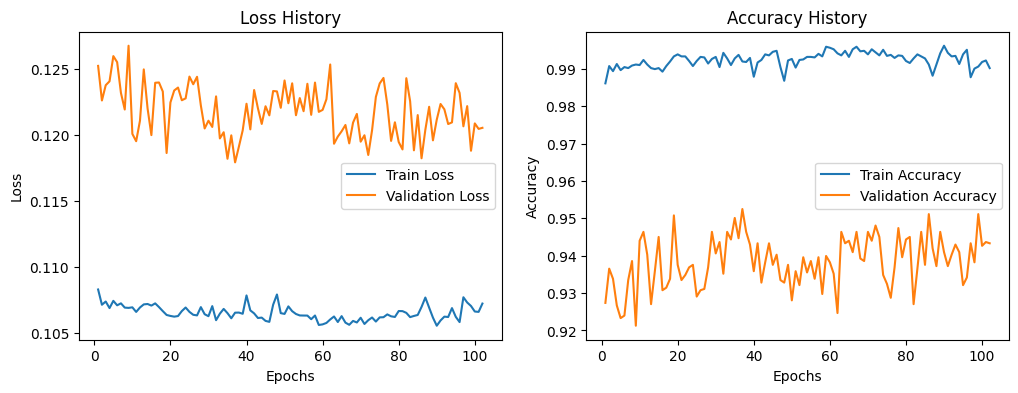

In [74]:
plot_history(history)

In [75]:
best_model = TCNWithAttention(n_length, n_features, n_outputs).to(device)
best_model.load_state_dict(torch.load('best_model.pth', weights_only = True))

val_correct = 0.0
with torch.no_grad():
    for input, target in test_loader:
        input = input.to(device)
        target = target.to(device)
    
        outputs = best_model(input)
        val_correct += (outputs.argmax(1) == target.argmax(1)).sum().item()
    print(f"val_acc: {val_correct / len(test_loader.dataset)}")

val_acc: 0.9324737020699015


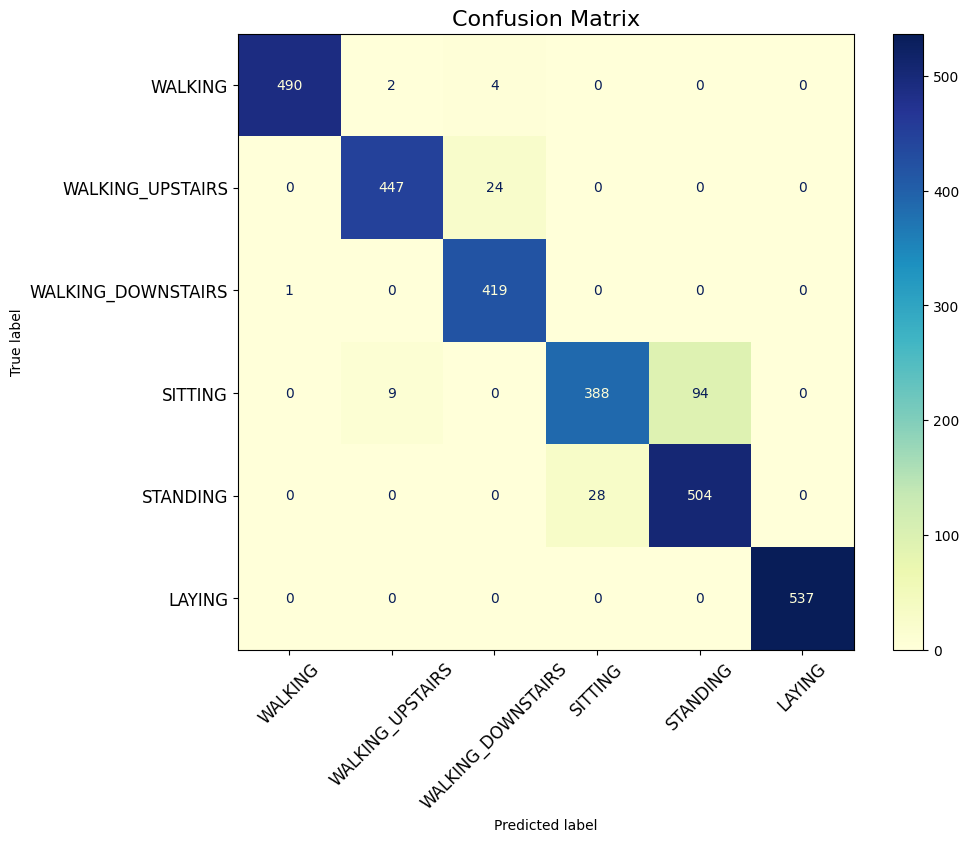

In [76]:
plot_confusion_matrix(best_model, test_loader, class_names=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"])

## Log

---
RNN (180k) + Attention + KL Div + Adam + CosineAnnealingLR ->  Train Acc: 0.9606; Val Acc: 0.9192 \
TCN (56k) + KL Div + Adam + StepLR -> Train Acc: 0.9698; Val Acc: 0.9355 \
TCN (56k) + KL Div + Adam + ConsineAnnealineLR -> Train Acc: 0.9921; Val Acc: 0.9382 \
TCN (250k) + KL Div + Adam + ConsineAnnealingLR -> Train Acc: 0.9871; Val Acc: 0.9484 \
TCN (50k) + CBAM + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9891; Val Acc: 0.9450 \
TCN (400k) + CBAM + KL Div + Adam + CosineAnnealingLR ->  Train Acc: 0.9970; Val Acc: 0.9545 \
Normalized + TCN (400k) + CBAM + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9931; Val Acc: 0.9498 \
Normalized + Noise + TCN (400k) + CBAM + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9962; Val Acc: 0.9511 \
Normalized + Noise + TCN (284k) + Self Attention + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9977; Val Acc: 0.9427 \
Normalized + Noise + TCN (539k) + Self Attention + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9944; Val Acc: 0.9569 \
Normalized + Noise + TCN (Dropouts(p=0.5) + BatchNorm) (539k) + Self Attention + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9932; Val Acc: 0.9623 \
Normalized + Noise + TCN (Dropouts(p=0.7) + BatchNorm) (539k) + Self Attention + KL Div + Adam + CosineAnnealingLR -> Train Acc: 0.9950; Val Acc: 0.9545 \
Model model with loss func `0.8*kl_div + 0.2*label_smoothing(0.1)` -> Train Acc: 0.9875; Val Acc: 0.9559 

In [ ]:
torch.cuda.memory_summary()

In [ ]:
torch.cuda.empty_cache()